In [1]:
import pandas as pd
import Auxiliary
import torch

In [2]:
Auxiliary.pipeline_kge('config.csv')

Training epochs on cuda:   0%|          | 0/50 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=8.


Evaluating on cuda:   0%|          | 0.00/5.42k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 253.38s seconds


In [2]:
path = 'V1/'
kg = pd.read_csv(path + 'train_set.ttl', sep='\t', header=None)
display(kg.shape, kg.head(2))

(4562470, 3)

,0,1,2
0,DB00001-P00734,type,DPI
1,DB00001-P00734,hasPubMedID,pubmed:10505536


# Unsupervised Learning¶
#### Save Learned Embeddings

In [3]:
m = 'TransH'  #RotatE
fold=1


# path = '../Cancer_treatment/Embeddings/KG versions/V4/Uniform/G2/'
print(path)
model = torch.load(path + m + str(fold) + '/trained_model.pkl')  # , map_location='cpu'


#model = torch.load('G/QuatE5/trained_model.pkl', map_location='cpu') #QuatE1
entity_embedding_tensor, relation_embedding_tensor =  Auxiliary.get_learned_embeddings(model)

V1/


## Computing clusters of the predicted heads by the model. Visualize PCA Projection to 2D
#### Creating dataframe with the embeddings predicted entities

In [4]:
tf_dataset, triple_dataset = Auxiliary.load_dataset(path, 'train_set.ttl')
entity = Auxiliary.filter_entity(kg, 'Drug:DB', 'uniprot:')

# tf_dataset, triple_dataset = load_dataset(path, 'train_1.ttl')
# entity = []
df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, entity, tf_dataset)

In [5]:
drug = [s for s in entity if 'Drug:DB' in s]
protein = [s for s in entity if 'uniprot:' in s]

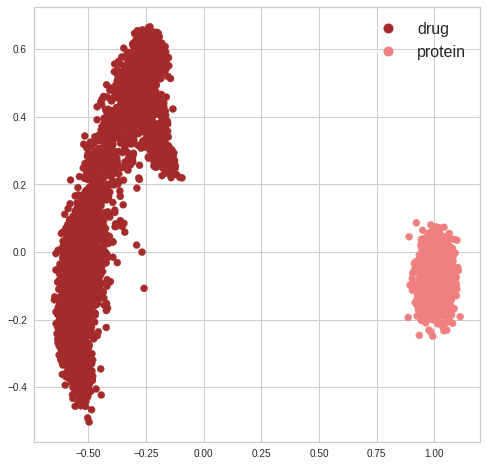

In [6]:
Auxiliary.plot_two_classes(new_df, drug, protein, 'drug', 'protein')

In [ ]:
new_df.to_csv('dataset/embedding_TransH1.csv', index=None)

## Select the optimal number of clusters
#### elbow: By default, the distortion score is computed, the sum of square distances from each point to its assigned center. 

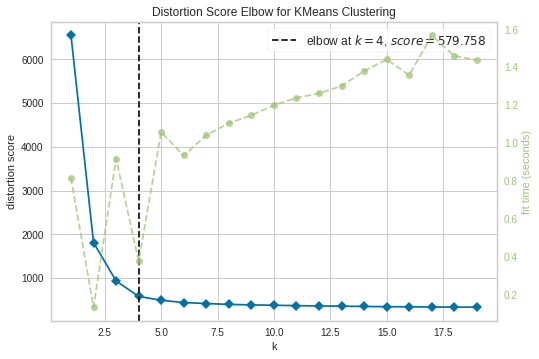

In [7]:
num_cls = Auxiliary.elbow_KMeans(df_predicted_entities, 1, 20)

## Visualize PCA Projection to 2D

/media/rivas/Data1/Projects/Project_Scientific_DB_Programming/Embedding/Auxiliary.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cluster'] = kmeans.fit_predict(new_df)
/media/rivas/Data1/Projects/Project_Scientific_DB_Programming/Embedding/Auxiliary.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['c'] = new_df.cluster.map(color_dictionary)


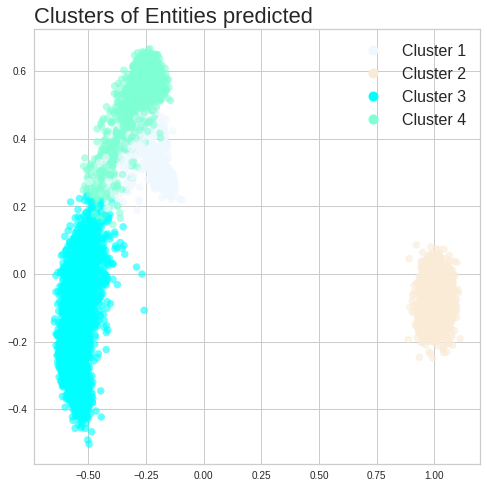

In [8]:
Auxiliary.plot_cluster(num_cls, df_predicted_entities, num_cls)

In [9]:
dpi = list(kg.loc[(kg[1]=='type') & (kg[2]=='DPI')][0].values)
ddi = list(kg.loc[(kg[1]=='type') & (kg[2]=='DDI')][0].values)
node = dpi + ddi

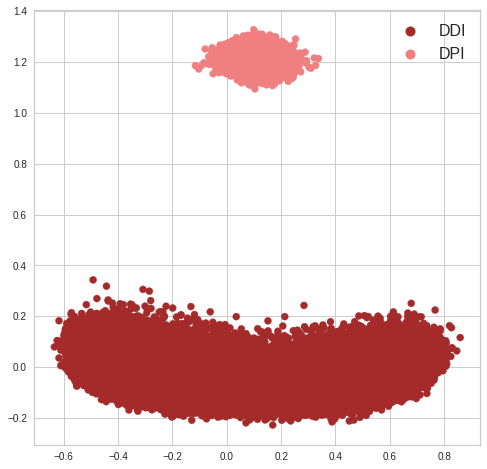

In [10]:
df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, node, tf_dataset)
Auxiliary.plot_two_classes(new_df, ddi, dpi, 'DDI', 'DPI')

In [11]:
d = list(kg.loc[(kg[1]=='type') & (kg[2]=='Drug')][0].values)
p = list(kg.loc[(kg[1]=='type') & (kg[2]=='Protein')][0].values)
node = node + d + p

df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, node, tf_dataset)

In [12]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
76562,-0.004083,0.014531,0.006570,0.003925,0.006270,0.014004,0.000936,-0.013768,0.004076,-0.001273,...,0.019458,-0.003520,0.028373,-0.006080,-0.002321,-0.000643,-0.342289,-0.007010,0.018370,DB00001-P00734
76564,-0.005590,0.013594,-0.004013,-0.002656,-0.003187,-0.004612,-0.011613,-0.000293,-0.021669,0.018313,...,-0.001222,0.005388,0.003729,-0.018110,0.005614,-0.007555,-0.338590,-0.013853,0.011068,DB00002-O75015
76565,-0.006512,0.000625,0.010175,-0.006466,-0.002354,-0.003582,-0.001954,0.001149,-0.002139,-0.000787,...,0.006993,-0.001022,-0.007209,-0.021083,-0.014002,-0.011545,-0.334176,-0.010413,-0.000440,DB00002-P00533
76566,0.002139,-0.001088,-0.004720,-0.004252,-0.002796,0.002066,0.000386,0.001977,-0.015928,-0.006214,...,0.003192,-0.000927,-0.001898,-0.024650,-0.002619,-0.004921,-0.344533,-0.005701,-0.001424,DB00002-P00736
76567,-0.007867,-0.006390,-0.013316,0.003401,0.003820,-0.002324,0.004344,0.001035,-0.014016,0.003484,...,-0.000390,0.000289,0.000058,-0.005590,0.006542,0.002377,-0.342867,0.000893,-0.012066,DB00002-P02745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953241,-0.027088,-0.010851,0.038788,0.020992,-0.008857,0.015874,0.005124,0.001439,0.004088,-0.021694,...,0.012296,-0.070077,-0.045423,-0.061392,0.020544,0.020509,-0.024844,-0.020157,0.042199,Protein:Q9Y6M9
953242,0.034624,0.020588,0.033577,0.010315,-0.022694,-0.006364,0.024436,0.008867,-0.061355,-0.016397,...,-0.008832,0.018040,-0.005936,-0.125581,-0.018582,-0.039541,0.050779,-0.065469,0.018689,Protein:Q9Y6R1
953243,-0.029526,-0.013387,-0.023822,0.029469,-0.013412,-0.029053,-0.033051,0.040116,-0.043095,-0.027024,...,-0.022994,-0.032968,-0.015168,-0.137651,-0.005413,-0.042465,-0.004433,0.002726,0.043894,Protein:Q9Y6Y9
953244,0.005561,0.016646,0.012469,-0.019344,0.004504,0.024411,-0.011095,-0.004646,-0.008112,-0.014681,...,0.013140,0.024165,-0.000333,-0.002102,0.004331,0.006114,-0.009400,-0.001577,0.027546,Protein:Q9Z4J7


In [13]:
entity_type = kg.loc[kg[1]=='type']
entity_type = dict(entity_type[[0,2]].values)
entity_type

{'DB00001-P00734': 'DPI',
 'DB00006-P00734': 'DPI',
 'DB00025-P00734': 'DPI',
 'DB00055-P00734': 'DPI',
 'DB00100-P00734': 'DPI',
 'DB00170-P00734': 'DPI',
 'DB00278-P00734': 'DPI',
 'DB01123-P00734': 'DPI',
 'DB01766-P00734': 'DPI',
 'DB01767-P00734': 'DPI',
 'DB02193-P00734': 'DPI',
 'DB02351-P00734': 'DPI',
 'DB02723-P00734': 'DPI',
 'DB03136-P00734': 'DPI',
 'DB03159-P00734': 'DPI',
 'DB03847-P00734': 'DPI',
 'DB03865-P00734': 'DPI',
 'DB04136-P00734': 'DPI',
 'DB04591-P00734': 'DPI',
 'DB04722-P00734': 'DPI',
 'DB04786-P00734': 'DPI',
 'DB04898-P00734': 'DPI',
 'DB06695-P00734': 'DPI',
 'DB06838-P00734': 'DPI',
 'DB06841-P00734': 'DPI',
 'DB06845-P00734': 'DPI',
 'DB06850-P00734': 'DPI',
 'DB06853-P00734': 'DPI',
 'DB06854-P00734': 'DPI',
 'DB06858-P00734': 'DPI',
 'DB06859-P00734': 'DPI',
 'DB06861-P00734': 'DPI',
 'DB06865-P00734': 'DPI',
 'DB06866-P00734': 'DPI',
 'DB06868-P00734': 'DPI',
 'DB06869-P00734': 'DPI',
 'DB06878-P00734': 'DPI',
 'DB06911-P00734': 'DPI',
 'DB06919-P0

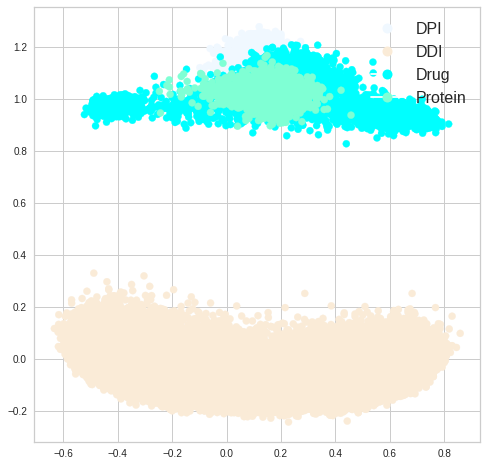

In [14]:
Auxiliary.plot_KGE(new_df, entity_type)

# Evaluation Metrics

In [15]:
tf_testing, triple_dataset = Auxiliary.load_dataset(path, 'test_set.ttl')
kg = pd.read_csv(path + 'test_set.ttl', sep='\t', header=None)
kg.columns = ['s', 'p', 'o']
serie = kg.s.value_counts()
dict_drug = serie.to_dict()
dict_drug

{'Drug:DB00157': 39,
 'Drug:DB00142': 25,
 'Drug:DB04315': 17,
 'Drug:DB01151': 16,
 'Drug:DB00363': 16,
 'Drug:DB03147': 16,
 'Drug:DB00143': 16,
 'Drug:DB03461': 15,
 'Drug:DB04464': 14,
 'Drug:DB00321': 14,
 'Drug:DB01238': 14,
 'Drug:DB04272': 13,
 'Drug:DB04395': 13,
 'Drug:DB02659': 13,
 'Drug:DB01992': 12,
 'Drug:DB02379': 12,
 'Drug:DB00396': 11,
 'Drug:DB08231': 11,
 'Drug:DB00683': 11,
 'Drug:DB00313': 11,
 'Drug:DB00514': 11,
 'Drug:DB00316': 11,
 'Drug:DB03247': 10,
 'Drug:DB00398': 10,
 'Drug:DB00171': 10,
 'Drug:DB00945': 10,
 'Drug:DB01026': 10,
 'Drug:DB00783': 9,
 'Drug:DB00909': 9,
 'Drug:DB01032': 9,
 'Drug:DB00624': 9,
 'Drug:DB08896': 9,
 'Drug:DB00690': 9,
 'Drug:DB06637': 9,
 'Drug:DB01239': 9,
 'Drug:DB01174': 9,
 'Drug:DB00246': 9,
 'Drug:DB01595': 9,
 'Drug:DB00114': 9,
 'Drug:DB00334': 9,
 'Drug:DB00515': 9,
 'Drug:DB00458': 9,
 'Drug:DB00145': 9,
 'Drug:DB01752': 9,
 'Drug:DB00675': 9,
 'Drug:DB00184': 9,
 'Drug:DB01159': 9,
 'Drug:DB01942': 9,
 'Drug:DB0073

In [16]:
kg_train = pd.read_csv(path + 'train_set.ttl', sep='\t', header=None)
kg_train.columns = ['s', 'p', 'o']
kg_train = kg_train.loc[kg_train.p=='interactsWith']
kg_train = kg_train[kg_train.s.str.contains('Drug:')]
kg_train

,s,p,o
4410184,Drug:DB00001,interactsWith,Protein:P00734
4410185,Drug:DB00006,interactsWith,Protein:P00734
4410186,Drug:DB00025,interactsWith,Protein:P00734
4410187,Drug:DB00055,interactsWith,Protein:P00734
4410188,Drug:DB00100,interactsWith,Protein:P00734
...,...,...,...
4422812,Drug:DB08912,interactsWith,Protein:P57059
4422813,Drug:DB08912,interactsWith,Protein:Q8NG66
4422814,Drug:DB08912,interactsWith,Protein:P53667
4422815,Drug:DB08930,interactsWith,Protein:P09086


In [17]:
precision_dict = dict()
recall_dict = dict()
f_measure_dict = dict()
for key, value in dict_drug.items():
    predicted_tails_df = Auxiliary.predict_tail(model, key, 'interactsWith', tf_testing)
    protein_train = list(kg_train.loc[(kg_train.s==key)].o.values)
    predicted_tails_df.loc[predicted_tails_df.tail_label.isin(protein_train), 'in_training']=True
    th = predicted_tails_df.in_training.value_counts()[True]
    precision, tp = Auxiliary.get_precision(predicted_tails_df, th)
    
#     recall = Auxiliary.get_recall(predicted_tails_df, tp)
#     f_measure = 0
#     if (precision + recall) > 0:
#         f_measure = Auxiliary.get_f_measure(precision, recall)
    
    precision_dict[key] = precision
#     recall_dict[key] = recall
#     f_measure_dict[key] = f_measure

In [18]:
avg_precision = 100*(sum(precision_dict.values()) / len(precision_dict))
avg_precision

0.20511699460592928

In [19]:
max(precision_dict.values())

0.5

In [89]:
# avg_recall = 100*(sum(recall_dict.values()) / len(recall_dict))
# avg_recall

In [90]:
# avg_f_measure = 100*(sum(f_measure_dict.values()) / len(f_measure_dict))
# avg_f_measure

(array([2.712e+03, 4.600e+01, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  8.6, 16.2, 23.8, 31.4, 39. ]),
 <BarContainer object of 5 artists>)

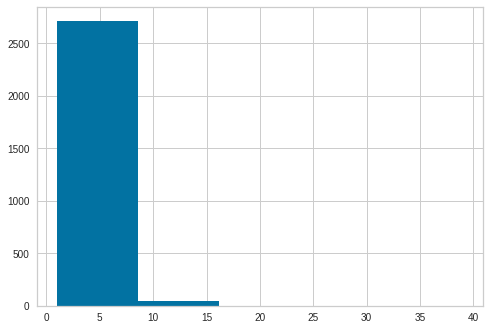

In [23]:
import matplotlib.pyplot as plt
plt.hist(dict_drug.values(), bins=5)